In [1]:
import os
os. chdir("../..")
os.getcwd()

'/Users/tonpoppe/workspace/graphcase_experiments/graphcase_experiments'

In [2]:
import networkx as nx
from graphcase_experiments.algos.GraphCaseWrapper import GraphCaseWrapper
from graphcase_experiments.algos.baselineWrapper import BaselineWrapper
from graphcase_experiments.tools.embedding_plotter import plot_embedding2, plotly_embedding
from graphcase_experiments.tools.calculate_embed import calculate_graphcase_embedding
import matplotlib.pyplot as plt
import pydot
import pandas as pd
import tensorflow as tf
import pyspark.sql.functions as F

/Users/tonpoppe/opt/anaconda3/envs/graphcase/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from graphcase_experiments.experiments.mooc_exp_copy import get_edge_data, mooc_train_test_split, prep_edges, get_mooc_graph
edges = get_edge_data()
train, test = mooc_train_test_split(20, edges)
train_edges = prep_edges(train)

G = get_mooc_graph(train_edges)

2022-09-12 18:58:03.697121: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


edges: 411749 mooc_action 411749
total count is 411749, test_cnt is 82349 and train_cnt is 329400: check_sum: 0
there are 145486 edges after selecting only the last one
input_df 145486, after adding labels 139240
edge colunms Index(['src', 'dst', 'weight', 'FEATURE0', 'FEATURE1', 'FEATURE2', 'FEATURE3',
       'FEATURE_COUNT', 'LABEL'],
      dtype='object')
edge check: df:139240, graph edges: 139240
node check: users+ courses:6795, nodes: 6795


In [4]:
G.number_of_edges()

140266

Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-09-12 19:01:50.137554: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


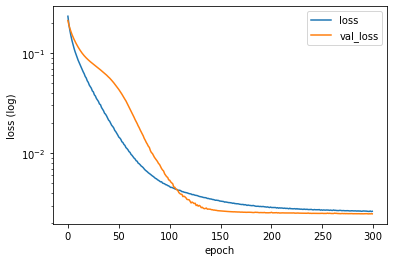

In [4]:
MOOC_PARAMS = {
        'batch_size': 1024,
        'hub0_feature_with_neighb_dim': 16,
        'verbose': False,
        'seed': 1,
        'encoder_labels': ['attr1', 'attr2'],
        'learning_rate': 0.001,
        'act': tf.nn.sigmoid,
        'useBN': True,
        'dropout': 0.1,
        'support_size': [5, 5],
        'dims': [4, 8,16,16],
        'epochs': 300,
    }
_, embed = calculate_graphcase_embedding(
            G, 'graphcase_experiments/data/mooc/', params=MOOC_PARAMS, verbose=True, algo=GraphCaseWrapper
        )



In [8]:
_, embed_baseline = calculate_graphcase_embedding(
            G, 'graphcase_experiments/data/mooc/', params=BaselineWrapper.MOOC_PARAMS, verbose=True, algo=BaselineWrapper
        )

In [5]:
plotly_embedding(embed.head(200))

/Users/tonpoppe/workspace/graphcase_experiments/graphcase_experiments/graphcase_experiments/tools/embedding_plotter.py:88: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_df['embed1'] = embed[:,0]
/Users/tonpoppe/workspace/graphcase_experiments/graphcase_experiments/graphcase_experiments/tools/embedding_plotter.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  embed_df['embed2'] = embed[:,1]


## performance on graphcase
including precision/recall curve and confusion matrix

In [6]:
from sklearn.metrics import ConfusionMatrixDisplay
from graphcase_experiments.experiments.mooc_exp_copy import prep_mdl_input, train_classifier, evaluate_clf
test_edges = prep_edges(test)

df_train_mdl = prep_mdl_input(train_edges, embed)
clf = train_classifier(df_train_mdl)
df_test_mdl = prep_mdl_input(test_edges, embed)
res = evaluate_clf(clf, df_test_mdl)

there are 40829 edges after selecting only the last one


pr auc 0.03438120559628275
avg precision ;0.035712118969002414


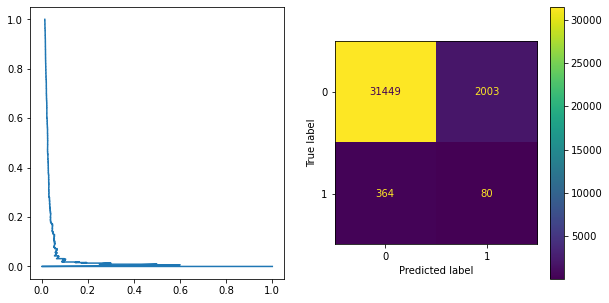

In [7]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc
precision, recall, thresholds = precision_recall_curve(df_test_mdl['label_id'], res['y_proba'][1])
roc = pd.DataFrame.from_dict({'precision': precision, 'recall': recall})
roc = roc.sort_values('recall')
print(f"pr auc {auc(roc['recall'], roc['precision'])}")
ap = average_precision_score(df_test_mdl['label_id'], res['y_proba'][1])
print(f"avg precision ;{ap}")
fig, axs = plt.subplots(1,2, figsize=((10,5)))
axs[0].plot(precision, recall)
ConfusionMatrixDisplay.from_predictions(df_test_mdl['label_id'], res['y_pred'], ax=axs[1])
plt.show()


## performance on baseline
including precision/recall curve and confusion matrix

In [52]:
df_train_mdl_baseline = prep_mdl_input(train, embed_baseline)
clf = train_classifier(df_train_mdl_baseline)
df_test_mdl_baseline = prep_mdl_input(test, embed_baseline)
res_baseline = evaluate_clf(clf, df_test_mdl_baseline)

pr auc 0.010775194137829095
avg precision ;0.012437595858297288


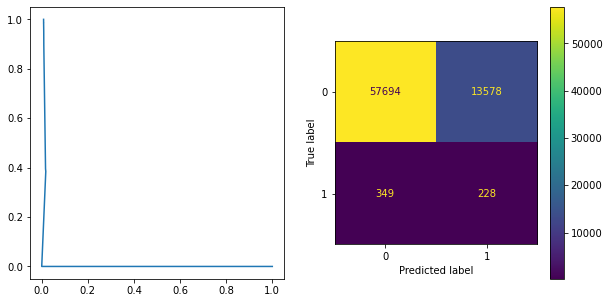

In [51]:
from sklearn.metrics import precision_recall_curve, average_precision_score, auc

precision, recall, thresholds = precision_recall_curve(df_test_mdl['label_id'], res_baseline['y_proba'][1])
roc = pd.DataFrame.from_dict({'precision': precision, 'recall': recall})
roc = roc.sort_values('recall')
print(f"pr auc {auc(roc['recall'], roc['precision'])}")
ap = average_precision_score(df_test_mdl['label_id'], res_baseline['y_proba'][1])
print(f"avg precision ;{ap}")
fig, axs = plt.subplots(1,2, figsize=((10,5)))
axs[0].plot(precision, recall)
ConfusionMatrixDisplay.from_predictions(df_test_mdl_baseline['label_id'], res_baseline['y_pred'], ax=axs[1])
plt.show()

## performance compared to other algos

In [3]:
from graphcase_experiments.experiments.mooc_exp import calc_mooc_performance, ALGO
details, smry = calc_mooc_performance(algos=ALGO, runs=5)

2022-09-06 19:22:01.866894: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


edges: 411749 mooc_action 411749
total count is 411749, test_cnt is 82349 and train_cnt is 329400: check_sum: 0
there are 145486 edges after selecting only the last one
edge check: df:145486, graph edges: 145486
node check: users+ courses:6795, nodes: 6795
Cause: mangled names are not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-09-06 19:25:46.032294: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.
/Users/tonpoppe/opt/anaconda3/envs/drne/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:458: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/tonpoppe/opt/anaconda3/envs/drne/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:459: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/tonpoppe/opt/anaconda3/envs/drne/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:460: FutureWarning: Passing (type, 1) or '1type' as a synonym of type 

In [ ]:
smry

auc_pr           avg_precision          
               mean       std          mean       std
algo                                                 
GraphCASE  0.023550  0.001373      0.024334  0.001368
baseline   0.010775  0.000000      0.012438  0.000000

In [ ]:
details